# EIP-4844 Fee Market Analysis: Simulation and Backtest

## Description

Proto-danksharding or [EIP-4844](https://eips.ethereum.org/EIPS/eip-4844) introduces a new transaction format for “blob-carrying transactions” which contain a large amount of data that cannot be accessed by EVM execution, but whose commitment can be accessed. The goal is to facilitate an ecosystem-wide move to rollups: Optimism and Arbitrum provide fees that are ~3-8x lower than the Ethereum base layer, and ZK rollups, which have better data compression and can avoid including signatures, have fees ~40-100x lower than the base layer.

The long-term scaling solution is still data sharding: add ~16 MB per block of dedicated data space to the chain that rollups could use. This EIP is an intermediate step which implements (1) same transaction format as sharding and (2) creates the gas fee market for this type of transactions, but has the following differences:

- No sharding of transactions: the data from blob transactions is fully downloaded by all consensus nodes (but can be deleted after only a relatively short delay)

- Reduced cap on the number of these transactions that can be included: target of ~0.25 MB per block and limit of ~0.5 MB

## Data Gas Fee Market

Data gas is introduced as a new type of gas that is only used to price blob transactions. It is independent of normal gas and follows its own targeting rule. The new pricing rule requires the `excess_data_gas` header field. The actual `data_fee` as calculated via `calc_data_fee` (see below) is deducted from the sender balance before transaction execution and burned, and is not refunded in case of transaction failure.

The data gasprice update rule approximates the formula

`data_gasprice = MIN_DATA_GASPRICE * e**(excess_data_gas / DATA_GASPRICE_UPDATE_FRACTION)`,

where `excess_data_gas` is the total “extra” amount of data gas that the chain has consumed relative to the “targeted” amount to date. Like EIP-1559, it’s a self-correcting formula: as the excess goes higher, the `data_gasprice` increases exponentially, reducing usage and eventually forcing the excess back down.

The block-by-block behavior is roughly as follows. If block `N` consumes `X` data gas, then in block `N+1` `excess_data_gas` increases by `X - TARGET_DATA_GAS_PER_BLOCK`, and so the `data_gasprice` of block `N+1` increases by a factor of 

`e**((X - TARGET_DATA_GAS_PER_BLOCK) / DATA_GASPRICE_UPDATE_FRACTION)`. 

Hence, it has a similar effect to the existing EIP-1559, but is more “stable” in the sense that it responds in the same way to the same total usage regardless of how it’s distributed.

The parameter `DATA_GASPRICE_UPDATE_FRACTION` controls the maximum rate of change of the blob gas price. It is chosen to target a maximum change rate of `e(TARGET_DATA_GAS_PER_BLOCK / DATA_GASPRICE_UPDATE_FRACTION) ≈ 1.125` per block.

## Setup

`Transaction` class:

- `max_fee_per_gas`: the max price that user is willing to pay.
- `max_priority_fee_per_gas`: the tip to the block producers.
- `gas_used`: gas resource required to execute transaction.

`BlobTransaction(Transaction)` class:

- `max_fee_per_data_gas`: the max data gasprice that user is willing to pay.
- `blob_hashes`: number of blobs included in transaction.


`generate_demand` function: generates demand for transactions. This is defined in each simulation instance as assumptions change.

`update_price` function: calculate resource prices using EIP-1559 formula according do deviation vs sustainable _resource target_: `new_price = price * (1 + ((utilized - target) / target) / 8)`.

`update_excess_data_gas` function: the excess data gas consumed (above the sustainable target) is computed according to the gas accounting formulas for blobs specified in the EIP.

`build_block` function: selects transactions, steps (1) filter out invalid txns for which gahimit is not enough and (2) build block respecting _resource limits_. Greedy block building logic where builder sorts by total gas premium and then selects transactions up to resource limit.

In [47]:
import secrets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend
from random import randint, uniform

sns.set(style="whitegrid")

In [48]:
constants = {
    # 1559 fee mechanism params 
    "BLOCK_RESOURCE_LIMITS": 30e6,
    "BLOCK_RESOURCE_TARGETS": 15e6,
    "BASEFEE_MAX_CHANGE_DENOMINATOR": 8,
    
    # 4844 fee mechanism params
    "MAX_DATA_GAS_PER_BLOCK": 2**19,
    "TARGET_DATA_GAS_PER_BLOCK": 2**18,
    "DATA_GAS_PER_BLOB": 2**17,
    "MIN_DATA_GASPRICE": 1,
    "DATA_GASPRICE_UPDATE_FRACTION": 2225652,
}

In [49]:
# helper function approximating exponential with taylor
def fake_exponential(factor: int, numerator: int, denominator: int) -> int:
    i = 1
    output = 0
    numerator_accum = factor * denominator
    while numerator_accum > 0:
        output += numerator_accum
        numerator_accum = (numerator_accum * numerator) // (denominator * i)
        i += 1
    return output // denominator

def calc_price_data(excess_data_gas) -> int:
    return fake_exponential(
        constants["MIN_DATA_GASPRICE"],
        excess_data_gas,
        constants["DATA_GASPRICE_UPDATE_FRACTION"]
    )

In [50]:
class Transaction:
    def __init__(self, max_priority_fee_per_gas, gas_used, max_fee_per_gas):
        self.tx_hash = secrets.token_bytes(6).hex()
        self.max_fee_per_gas = max_fee_per_gas
        self.max_priority_fee_per_gas = max_priority_fee_per_gas
        self.gas_used = gas_used

    def is_valid(self, price, price_data):
        return self.max_fee_per_gas >= price
    
    def get_premium(self, price):
        priority_fee = min(self.max_fee_per_gas - price, self.max_priority_fee_per_gas)
        return self.gas_used * priority_fee

class BlobTransaction(Transaction):
    def __init__(self, max_priority_fee_per_gas, gas_used, max_fee_per_gas, max_fee_per_data_gas, blob_hashes):
        super().__init__(max_priority_fee_per_gas, gas_used, max_fee_per_gas)
        self.max_fee_per_data_gas = max_fee_per_data_gas
        self.blob_hashes = blob_hashes
    
    def is_valid(self, price, price_data):
        return self.max_fee_per_gas >= price and self.max_fee_per_data_gas >= price_data

class Block():
    def __init__(self, txs):
        self.txs = txs

In [51]:
# 1559 fee mechanism
def update_price(params, step, h, s, _input):
    block = _input["block"]
    price = s["price"]
    
    target = constants["BLOCK_RESOURCE_TARGETS"]
    utilized = sum([tx.gas_used for tx in block.txs]) 
    new_price = price * (1 + (utilized - target) / (target * constants["BASEFEE_MAX_CHANGE_DENOMINATOR"]))
    
    return ("price", new_price)

In [52]:
# 4844 fee mechanism
def update_excess_data_gas(params, step, h, s, _input):
    block = _input["block"]
    excess_data_gas = s["excess_data_gas"]
    
    target = constants["TARGET_DATA_GAS_PER_BLOCK"]
    utilized = constants["DATA_GAS_PER_BLOB"] * sum([tx.blob_hashes if isinstance(tx, BlobTransaction) else 0 for tx in block.txs]) 
    new_excess_data_gas = max(excess_data_gas + (utilized - target), 0)

    return ("excess_data_gas", new_excess_data_gas)

In [53]:
def build_block(params, step, h, s):
    demand = s["demand"]
    price = s["price"]
    excess_data_gas = s["excess_data_gas"]
    price_data = calc_price_data(excess_data_gas)
    
    # select valid transactions and sort them by total gas premium
    # for BlobTransaction we check validity against price_data too
    sorted_valid_demand = sorted(
        [tx for tx_hash, tx in demand.items() if tx.is_valid(price, price_data)],
        key = lambda tx: -tx.get_premium(price)
    )
    
    gas_limit = constants["BLOCK_RESOURCE_LIMITS"]
    data_limit = constants["MAX_DATA_GAS_PER_BLOCK"]
    included_transactions = []
    utilized = 0
    utilized_data = 0
    for tx in sorted_valid_demand:
        if utilized<=gas_limit:
            if isinstance(tx, BlobTransaction):
                if tx.blob_hashes * constants["DATA_GAS_PER_BLOB"] + utilized_data<=data_limit:
                    included_transactions.append(tx)
                    utilized += tx.gas_used
                    utilized_data += tx.blob_hashes * constants["DATA_GAS_PER_BLOB"]
                elif isinstance(tx, BlobTransaction) and utilized_data>=data_limit:
                    continue
            else:
                included_transactions.append(tx)
                utilized += tx.gas_used
        else:
            break

    return ({"block": Block(txs=included_transactions)})


def record_latest_block(params, step, h, s, _input):
    block = _input["block"]
    return ("latest_block", block)

# Simulations

## Basic Case

In [54]:

def generate_demand(params, step, h, s, _input):

    demand = {}  
    for i in range(1000):
        tx = Transaction(
            gas_used = 50000,
            max_fee_per_gas = 100*uniform(0.75,1.25),
            max_priority_fee_per_gas = uniform(1, 10), # ~1/10 of max fee to represent builder "cost"
        )
        demand[tx.tx_hash] = tx

    for i in range(10):
        tx = BlobTransaction(
            gas_used = 50000,
            max_fee_per_gas = 150*uniform(0.75,1.25),
            max_priority_fee_per_gas = uniform(1, 10),
            max_fee_per_data_gas = 50*uniform(0.75,1.25),
            blob_hashes = 2
        )
        demand[tx.tx_hash] = tx

    return ("demand", demand)

def generate_demand_full(params, step, h, s, _input):

    demand = {}  
    for i in range(1000):
        tx = Transaction(
            gas_used = 50000,
            max_fee_per_gas = 100*uniform(0.75,1.25),
            max_priority_fee_per_gas = uniform(1, 10), # ~1/10 of max fee to represent builder "cost"
        )
        demand[tx.tx_hash] = tx

    for i in range(10):
        tx = BlobTransaction(
            gas_used = 50000,
            max_fee_per_gas = 150*uniform(0.75,1.25),
            max_priority_fee_per_gas = uniform(1, 10),
            max_fee_per_data_gas = 50*uniform(0.75,1.25),
            blob_hashes = 2
        )
        demand[tx.tx_hash] = tx

    return ("demand", demand)
  
def generate_demand_impulse(params, step, h, s, _input):
   
    demand = {}  
    if h[-1][-1]['timestep'] > 50:
        return ("demand", demand)
    for i in range(1000):
        tx = Transaction(
            gas_used = 50000,
            max_fee_per_gas = 100*uniform(0.75,1.25),
            max_priority_fee_per_gas = uniform(1, 10), # ~1/10 of max fee to represent builder "cost"
        )
        demand[tx.tx_hash] = tx

    for i in range(10):
        tx = BlobTransaction(
            gas_used = 50000,
            max_fee_per_gas = 150*uniform(0.75,1.25),
            max_priority_fee_per_gas = uniform(1, 10),
            max_fee_per_data_gas = 50*uniform(0.75,1.25),
            blob_hashes = 2
        )
        demand[tx.tx_hash] = tx

    return ("demand", demand)

In [55]:
%%capture

psub = [{
    "policies": {},
    "variables": {
        "demand": generate_demand_impulse
    }
}, {
    "policies": {
        "action": build_block
    },
    "variables": {
        "excess_data_gas": update_excess_data_gas,
        "price": update_price,
        "latest_block": record_latest_block,
    }
}]

initial_conditions = {
    "price": 1,
    "excess_data_gas": 0,
    "demand": {},
    "latest_block": Block(txs=[])
}

simulation_parameters = {
    'T': 100,
    'N': 1,
    'M': {}
}

model = Model(
    initial_state=initial_conditions,
    state_update_blocks=psub,
    params=simulation_parameters
)

simulation = Simulation(
    model=model,
    timesteps=simulation_parameters['T'],
    runs=simulation_parameters['N']
)

experiment = Experiment(simulations=[simulation])
#experiment.engine=Engine(backend=Backend.PATHOS, drop_substeps=True)
experiment.engine=Engine(backend=Backend.SINGLE_PROCESS, drop_substeps=True)

df = pd.DataFrame(experiment.run())

In [56]:
df

,price,excess_data_gas,demand,latest_block,simulation,subset,run,substep,timestep
0,1.000000,0,{},<__main__.Block object at 0x345a95a30>,0,0,1,0,0
1,1.125417,262144,{'fb3a278ff0a8': <__main__.Transaction object ...,<__main__.Block object at 0x345b66b50>,0,0,1,2,1
2,1.266563,524288,{'15eddaec07d1': <__main__.Transaction object ...,<__main__.Block object at 0x345c403d0>,0,0,1,2,2
3,1.425411,786432,{'3926ff697a1e': <__main__.Transaction object ...,<__main__.Block object at 0x345cca790>,0,0,1,2,3
4,1.604181,1048576,{'52389928e85b': <__main__.Transaction object ...,<__main__.Block object at 0x345d43b50>,0,0,1,2,4
...,...,...,...,...,...,...,...,...,...
96,0.268764,0,{},<__main__.Block object at 0x346883400>,0,0,1,2,96
97,0.235169,0,{},<__main__.Block object at 0x3468834c0>,0,0,1,2,97
98,0.205773,0,{},<__main__.Block object at 0x3468833d0>,0,0,1,2,98
99,0.180051,0,{},<__main__.Block object at 0x346883340>,0,0,1,2,99


<Axes: xlabel='timestep'>

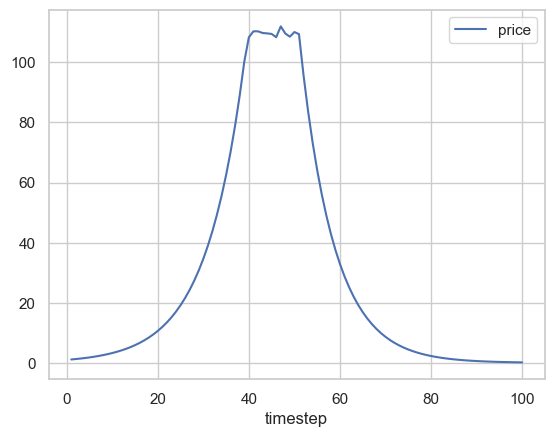

In [57]:
df[df.substep == 2].plot('timestep', ['price'])

<Axes: xlabel='timestep'>

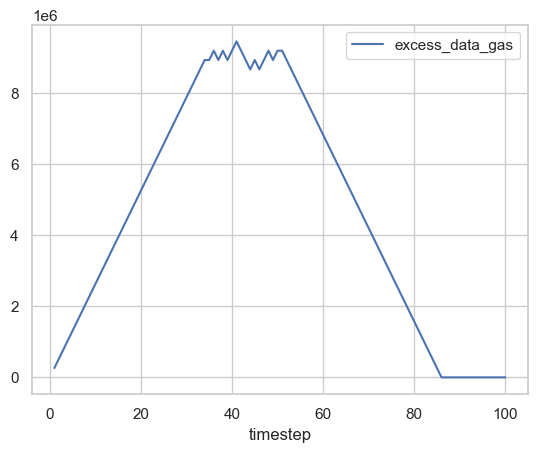

In [58]:
df[df.substep == 2].plot('timestep', ['excess_data_gas'])

<Axes: xlabel='timestep'>

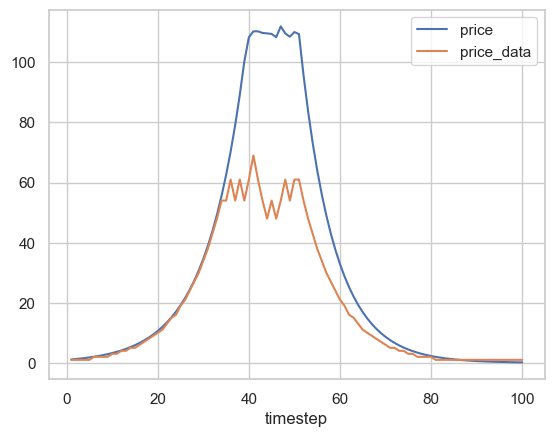

In [59]:
df['price_data'] = df['excess_data_gas'].apply(lambda x: calc_price_data(x))
df[df.substep == 2].plot('timestep', ['price', 'price_data'])

# Backtest switching to blob txs

We now do a backtest considering the 98%+ percent of the current batch-data load that is given by Arbitrum and Optimism. We chose the day with the highest batch-data load in the first two months of 2023, February 24th.

- Arbitrum posted 1055 consistent batches of ~99kb (600b stdev) every 6.78 blocks on avg, for a total of ~100mb/day
- Optimism posted 2981 variable batches of avg ~31kb (19kb stdev) every 2.37 blocks on avg, for a total of ~93mb/day

Note that all gas accounting in 4844 is done using blobs and their fixed capacity size of 2**17b (~125kb).

**Case 1** considers a scenario with a data load which is slightly higher (1.5x) than the historical data from the peak day considered. For convenience, we assume that L2s do not optimize their batch sizes (okay for ARB but suboptimal for OP) which results in a likely overestimation of the blobs demand. Results show that this load is not enough to start moving the data price.

**Case 2** consider the case in which data load is inflated by roughly 10x, a value that is just enough to kickstart the data price discovery process.

We start with loading historical data (for original query and more stats for this data check out the data-processing-utils notebook in the same folder).

In [60]:
# original sim data
demand_input = pd.read_csv('data/data.csv.gz', index_col=False)

# arbitrum spike
#demand_input = pd.read_csv('data/bq-results-20230323.csv.gz', index_col=False)

# op spike
#demand_input = pd.read_csv('data/bq-results-20230727.csv.gz', index_col=False)

# another spike
#demand_input = pd.read_csv('data/bq-results-20230417.csv.gz', index_col=False)

# another spike
#demand_input = pd.read_csv('data/bq-results-20230324.csv.gz', index_col=False)
demand_input.head()

,block_number,hash,index,gas_limit,gas_price,gas_used,max_fee_per_gas,max_priority_fee_per_gas,base_fee,status,type,data_tag,data_bytes
0,16694518,0xc1b634a544a70f37f9bf919811d7fdf019454c1845a2...,12,350000,36759710743,102137,NaN,NaN,29012091945,1,0,other,228
1,16694518,0x847491b60da6c0820dd652ca6c1d56290ff6694a2af1...,45,90000,31012091945,32140,2.000000e+11,2.000000e+09,29012091945,1,2,other,68
2,16694518,0x1fafbdf2814714a01f3ab66c7e3afdd18643e193621f...,69,207128,31012091945,41321,3.500000e+10,2.000000e+09,29012091945,1,2,other,68
3,16694518,0x14332e878aaac274961910507ea167d91f96ae7d5d8a...,81,116472,30412091945,55979,3.500000e+10,1.400000e+09,29012091945,1,2,other,36
4,16694518,0x1bae5eb49ed369e705e671f73f958994921d1fdcb59d...,42,420000,31012091945,51907,5.932647e+10,2.000000e+09,29012091945,1,2,other,68


In [61]:
demand_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095771 entries, 0 to 1095770
Data columns (total 13 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   block_number              1095771 non-null  int64  
 1   hash                      1095771 non-null  object 
 2   index                     1095771 non-null  int64  
 3   gas_limit                 1095771 non-null  int64  
 4   gas_price                 1095771 non-null  int64  
 5   gas_used                  1095771 non-null  int64  
 6   max_fee_per_gas           947423 non-null   float64
 7   max_priority_fee_per_gas  947423 non-null   float64
 8   base_fee                  1095771 non-null  int64  
 9   status                    1095771 non-null  int64  
 10  type                      1095771 non-null  int64  
 11  data_tag                  1095771 non-null  object 
 12  data_bytes                1095771 non-null  int64  
dtypes: float64(2), int64(9), ob

## Case 1: historical demand x1.5

In [62]:
def generate_demand_from_data(params, step, h, s, _input):

    di = demand_input[demand_input['block_number']==(min(demand_input['block_number'])+len(h))].to_dict('index')

    demand = {}
    for key, val in di.items():
        if val['data_tag']=='other':
            tx = Transaction(
                gas_used = val['gas_used'],
                max_fee_per_gas = val['max_fee_per_gas'],
                max_priority_fee_per_gas = val['max_priority_fee_per_gas'],
            )
        else:
            tx = BlobTransaction(
                gas_used = 50000,
                max_fee_per_gas = val['max_fee_per_gas'],
                max_priority_fee_per_gas = val['max_priority_fee_per_gas'],
                max_fee_per_data_gas = 50e9,
                blob_hashes = 1
            )
        demand[tx.tx_hash] = tx

    return ("demand", demand)


def build_block_from_data(params, step, h, s):
    demand = s["demand"]
    price = s["price"]
    excess_data_gas = s["excess_data_gas"]
    price_data = calc_price_data(excess_data_gas)
    
    # REMOVE selection, include everything for now
    sorted_valid_demand = [tx for tx_hash, tx in demand.items()]
    
    gas_limit = constants["BLOCK_RESOURCE_LIMITS"]
    data_limit = constants["MAX_DATA_GAS_PER_BLOCK"]
    included_transactions = []
    utilized = 0
    utilized_data = 0
    for tx in sorted_valid_demand:
        if utilized<=gas_limit:
            if isinstance(tx, BlobTransaction):
                if tx.blob_hashes * constants["DATA_GAS_PER_BLOB"] + utilized_data<=data_limit:
                    included_transactions.append(tx)
                    utilized += tx.gas_used
                    utilized_data += tx.blob_hashes * constants["DATA_GAS_PER_BLOB"]
                elif isinstance(tx, BlobTransaction) and utilized_data>=data_limit:
                    continue
            else:
                included_transactions.append(tx)
                utilized += tx.gas_used
        else:
            break

    return ({"block": Block(txs=included_transactions)})

In [63]:
%%capture

psub = [{
    "policies": {},
    "variables": {
        "demand": generate_demand_from_data
    }
}, {
    "policies": {
        "action": build_block_from_data
    },
    "variables": {
        "excess_data_gas": update_excess_data_gas,
        "price": update_price,
        "latest_block": record_latest_block,
    }
}]

initial_conditions = {
    "price": 28543674071,
    "excess_data_gas": 0,
    "demand": {},
    "latest_block": Block(txs=[])
}

simulation_parameters = {
    'T': 600,
    'N': 1,
    'M': {}
}

model = Model(
    initial_state=initial_conditions,
    state_update_blocks=psub,
    params=simulation_parameters
)

simulation = Simulation(
    model=model,
    timesteps=simulation_parameters['T'],
    runs=simulation_parameters['N']
)

experiment = Experiment(simulations=[simulation])
experiment.engine=Engine(backend=Backend.SINGLE_PROCESS, drop_substeps=True)
df = pd.DataFrame(experiment.run())

In [64]:
df.tail(10)

,price,excess_data_gas,demand,latest_block,simulation,subset,run,substep,timestep
591,5.659428e+09,0,{'5f9f88aa9ec1': <__main__.Transaction object ...,<__main__.Block object at 0x36ccb2c70>,0,0,1,2,591
592,5.684360e+09,0,{'f9da5e0d96af': <__main__.Transaction object ...,<__main__.Block object at 0x36cce3d90>,0,0,1,2,592
593,5.862751e+09,0,{'8df41c0d681e': <__main__.Transaction object ...,<__main__.Block object at 0x36cd0be80>,0,0,1,2,593
594,5.836491e+09,0,{'10e4a4743fe1': <__main__.Transaction object ...,<__main__.Block object at 0x36cd25a00>,0,0,1,2,594
595,5.789765e+09,0,{'78a28833d3a0': <__main__.Transaction object ...,<__main__.Block object at 0x36cd23fa0>,0,0,1,2,595
596,5.764390e+09,0,{'d7e7f14ca0c2': <__main__.Transaction object ...,<__main__.Block object at 0x36cd37820>,0,0,1,2,596
597,5.676094e+09,0,{'81a076c71d42': <__main__.Transaction object ...,<__main__.Block object at 0x36cd54f40>,0,0,1,2,597
598,5.713027e+09,0,{'f5a8671a298d': <__main__.Transaction object ...,<__main__.Block object at 0x36cd7a850>,0,0,1,2,598
599,5.446873e+09,0,{'9ffb0c804de0': <__main__.Transaction object ...,<__main__.Block object at 0x36cd83400>,0,0,1,2,599
600,5.437838e+09,0,{'db4fc020b3ab': <__main__.Transaction object ...,<__main__.Block object at 0x36cd98b50>,0,0,1,2,600


<Axes: >

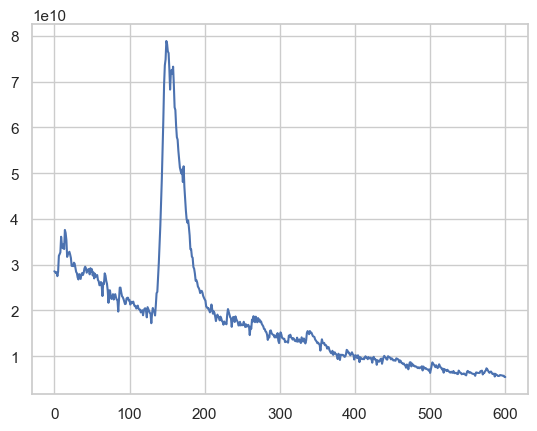

In [65]:
df['price'].plot()

<Axes: xlabel='timestep'>

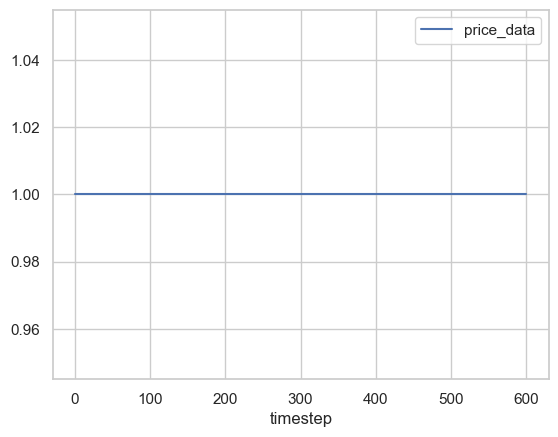

In [66]:
df['price_data'] = df['excess_data_gas'].apply(lambda x: calc_price_data(x))
df[df.substep == 2].plot('timestep', ['price_data'])

<Axes: xlabel='block_number'>

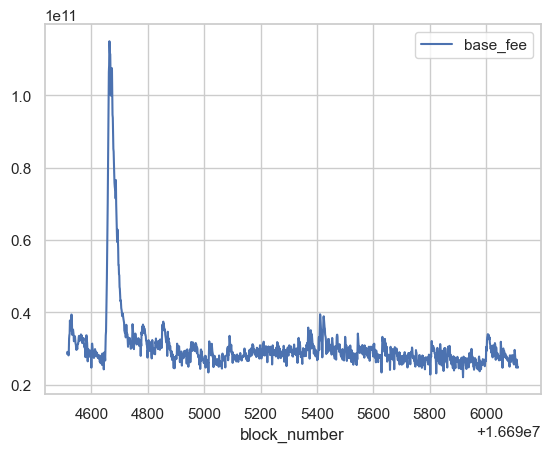

In [67]:
demand_input[['block_number', 'base_fee']].groupby('block_number').min().head(1600).plot()

Additional note: Comparing the gas price to the base fee from the original data we see that moving to batches to blobs as a deflationary effect on normal gas price (as expected).

## Case 2: historical demand x3 + 4 blobs every 3 blocks = historical demand ~x10

In [68]:
def generate_demand_from_data(params, step, h, s, _input):

    di = demand_input[demand_input['block_number']==(min(demand_input['block_number'])+len(h))].to_dict('index')
    
    demand = {}
    for key, val in di.items():
        if val['data_tag']=='other':
            tx = Transaction(
                gas_used = val['gas_used'],
                max_fee_per_gas = val['max_fee_per_gas'],
                max_priority_fee_per_gas = val['max_priority_fee_per_gas'],
            )
        else:
            tx = BlobTransaction(
                gas_used = 50000,
                max_fee_per_gas = val['max_fee_per_gas'],
                max_priority_fee_per_gas = val['max_priority_fee_per_gas'],
                max_fee_per_data_gas = 50e9*uniform(0.75,1.25),
                blob_hashes = 2
            )
        demand[tx.tx_hash] = tx
    
    if (len(h) % 3)==0:
        for i in range(2):
            tx = BlobTransaction(
                gas_used = 50000,
                max_fee_per_gas = 150e9*uniform(0.75,1.25),
                max_priority_fee_per_gas = 1e9*uniform(1, 10),
                max_fee_per_data_gas = 50e9*uniform(0.75,1.25),
                blob_hashes = 2
            )
            demand[tx.tx_hash] = tx

    return ("demand", demand)


def build_block_from_data(params, step, h, s):
    demand = s["demand"]
    price = s["price"]
    excess_data_gas = s["excess_data_gas"]
    price_data = calc_price_data(excess_data_gas)

    # select valid transactions and sort them by total gas premium
    # for BlobTransaction we check validity against price_data too
    sorted_valid_demand = sorted(
        [tx for tx_hash, tx in demand.items() if tx.is_valid(price, price_data)],
        key = lambda tx: -tx.get_premium(price)
    )
    
    gas_limit = constants["BLOCK_RESOURCE_LIMITS"]
    data_limit = constants["MAX_DATA_GAS_PER_BLOCK"]
    included_transactions = []
    utilized = 0
    utilized_data = 0
    for tx in sorted_valid_demand:
        if utilized<=gas_limit:
            if isinstance(tx, BlobTransaction):
                if tx.blob_hashes * constants["DATA_GAS_PER_BLOB"] + utilized_data<=data_limit:
                    included_transactions.append(tx)
                    utilized += tx.gas_used
                    utilized_data += tx.blob_hashes * constants["DATA_GAS_PER_BLOB"]
                elif isinstance(tx, BlobTransaction) and utilized_data>=data_limit:
                    continue
            else:
                included_transactions.append(tx)
                utilized += tx.gas_used
        else:
            break

    return ({"block": Block(txs=included_transactions)})

In [42]:
def generate_demand_from_data(params, step, h, s, _input):

    di = demand_input[demand_input['block_number']==(min(demand_input['block_number'])+len(h))].to_dict('index')
    
    demand = {}
    for key, val in di.items():
        if val['data_tag']=='other':
            tx = Transaction(
                gas_used = val['gas_used'],
                max_fee_per_gas = val['max_fee_per_gas'],
                max_priority_fee_per_gas = val['max_priority_fee_per_gas'],
            )
        else:
            tx = BlobTransaction(
                gas_used = 50000,
                max_fee_per_gas = val['max_fee_per_gas'],
                max_priority_fee_per_gas = val['max_priority_fee_per_gas'],
                max_fee_per_data_gas = 50e9*uniform(0.75,1.25),
                blob_hashes = 2
            )
        demand[tx.tx_hash] = tx
    
    if (len(h) % 3)==0:
        for i in range(2):
            tx = BlobTransaction(
                gas_used = 50000,
                max_fee_per_gas = 150e9*uniform(0.75,1.25),
                max_priority_fee_per_gas = 1e9*uniform(1, 10),
                max_fee_per_data_gas = 50e9*uniform(0.75,1.25),
                blob_hashes = 2
            )
            demand[tx.tx_hash] = tx

    return ("demand", demand)


def build_block_from_data(params, step, h, s):
    demand = s["demand"]
    price = s["price"]
    excess_data_gas = s["excess_data_gas"]
    price_data = calc_price_data(excess_data_gas)

    # select valid transactions and sort them by total gas premium
    # for BlobTransaction we check validity against price_data too
    sorted_valid_demand = sorted(
        [tx for tx_hash, tx in demand.items() if tx.is_valid(price, price_data)],
        key = lambda tx: -tx.get_premium(price)
    )
    
    gas_limit = constants["BLOCK_RESOURCE_LIMITS"]
    data_limit = constants["MAX_DATA_GAS_PER_BLOCK"]
    included_transactions = []
    utilized = 0
    utilized_data = 0
    for tx in sorted_valid_demand:
        if utilized<=gas_limit:
            if isinstance(tx, BlobTransaction):
                if tx.blob_hashes * constants["DATA_GAS_PER_BLOB"] + utilized_data<=data_limit:
                    included_transactions.append(tx)
                    utilized += tx.gas_used
                    utilized_data += tx.blob_hashes * constants["DATA_GAS_PER_BLOB"]
                elif isinstance(tx, BlobTransaction) and utilized_data>=data_limit:
                    continue
            else:
                included_transactions.append(tx)
                utilized += tx.gas_used
        else:
            break

    return ({"block": Block(txs=included_transactions)})

In [43]:
%%capture

psub = [{
    "policies": {},
    "variables": {
        "demand": generate_demand_from_data
    }
}, {
    "policies": {
        "action": build_block_from_data
    },
    "variables": {
        "excess_data_gas": update_excess_data_gas,
        "price": update_price,
        "latest_block": record_latest_block,
    }
}]

initial_conditions = {
    "price": 28543674071,
    "excess_data_gas": 0,
    "demand": {},
    "latest_block": Block(txs=[])
}

simulation_parameters = {
    'T': 8000,
    'N': 1,
    'M': {}
}

model = Model(
    initial_state=initial_conditions,
    state_update_blocks=psub,
    params=simulation_parameters
)

simulation = Simulation(
    model=model,
    timesteps=simulation_parameters['T'],
    runs=simulation_parameters['N']
)

experiment = Experiment(simulations=[simulation])
experiment.engine=Engine(backend=Backend.SINGLE_PROCESS, drop_substeps=True)
df = pd.DataFrame(experiment.run())

In [44]:
df.tail(10)

,price,excess_data_gas,demand,latest_block,simulation,subset,run,substep,timestep
7991,1.298365e-87,0,{},<__main__.Block object at 0x3459f84f0>,0,0,1,2,7991
7992,1.137152e-87,262144,{'2ab5e877a183': <__main__.BlobTransaction obj...,<__main__.Block object at 0x3459f8dc0>,0,0,1,2,7992
7993,9.950076e-88,0,{},<__main__.Block object at 0x3459f8c40>,0,0,1,2,7993
7994,8.706317e-88,0,{},<__main__.Block object at 0x3459f8250>,0,0,1,2,7994
7995,7.625282e-88,262144,{'47d62dc99f0e': <__main__.BlobTransaction obj...,<__main__.Block object at 0x3459f8430>,0,0,1,2,7995
7996,6.672122e-88,0,{},<__main__.Block object at 0x3459f8ca0>,0,0,1,2,7996
7997,5.838107e-88,0,{},<__main__.Block object at 0x3459f87c0>,0,0,1,2,7997
7998,5.113208e-88,262144,{'017204c691ee': <__main__.BlobTransaction obj...,<__main__.Block object at 0x3459f87f0>,0,0,1,2,7998
7999,4.474057e-88,0,{},<__main__.Block object at 0x3459f8760>,0,0,1,2,7999
8000,3.914800e-88,0,{},<__main__.Block object at 0x3459f84c0>,0,0,1,2,8000


<Axes: xlabel='timestep'>

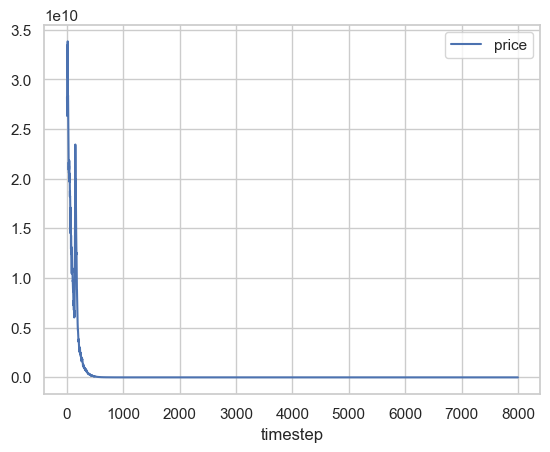

In [45]:
df[df.substep == 2].plot('timestep', ['price'])

<Axes: xlabel='timestep'>

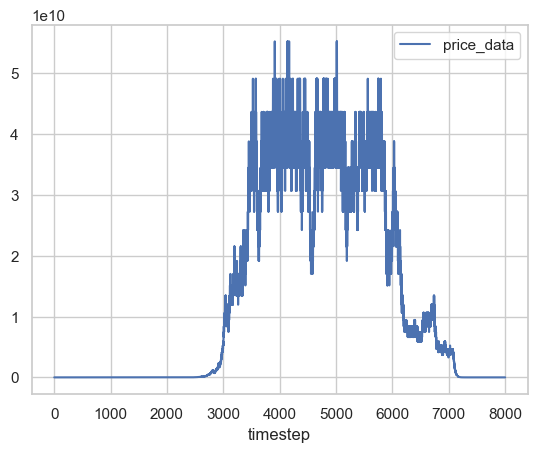

In [46]:
df['price_data'] = df['excess_data_gas'].apply(lambda x: calc_price_data(x))
df[df.substep == 2].plot('timestep', ['price_data'])

## Resources

- [Dune query for explorations](https://dune.com/queries/2173699?sidebar=query-explorer)
- [Dan Boneh lecture on EVM resources](https://cs251.stanford.edu/lectures/lecture8.pdf)